In [57]:
from IPython.display import display, clear_output
import math
import time

In [113]:
import numpy as np

### Расчёт потенциала по координатам точек с помощью numpy

In [138]:
n = 5
x = np.random.rand(n, 3)
xxt = x.dot(x.T)
d = np.diag(xxt)
p_roll = d.reshape(1, -1).repeat(n, axis=0)
q_roll = d.reshape(-1, 1).repeat(n, axis=1)
sq_dist = p_roll + q_roll - 2 * np.diag(d)
dist = np.sqrt(sq_dist)
dist_one = dist + np.eye(n)
rec_dist_one = 1 / dist_one
all_interactions = rec_dist_one - np.eye(n) + (np.sqrt(d) - np.ones(n))**2
t = all_interactions.sum()

### Рисование сфер

In [140]:
import vapory
from PIL import Image

In [141]:
def create_scene(moment):
    angle = 2 * math.pi * moment / 360
    r_camera = 7
    camera = vapory.Camera('location', [r_camera * math.cos(angle), 1.5, r_camera * math.sin(angle)], 'look_at', [0, 0, 0], 'angle', 30)
    light1 = vapory.LightSource([2, 4, -3], 'color', [1, 1, 1])
    light2 = vapory.LightSource([2, 4, 3], 'color', [1, 1, 1])
    plane = vapory.Plane([0, 1, 0], -1, vapory.Pigment('color', [1, 1, 1]))
    box = vapory.Box([0, 0, 0], [1, 1, 1], 
                     vapory.Pigment('Col_Glass_Clear'),
                     vapory.Finish('F_Glass9'),
                     vapory.Interior('I_Glass1'))
    spheres = [vapory.Sphere( [float(r[0]), float(r[1]), float(r[2])], 0.05, vapory.Texture(vapory.Pigment('color', [1, 1, 0]))) for r in x]
    return vapory.Scene(camera, objects=[light1, light2, plane, box] + spheres, included=['glass.inc'])

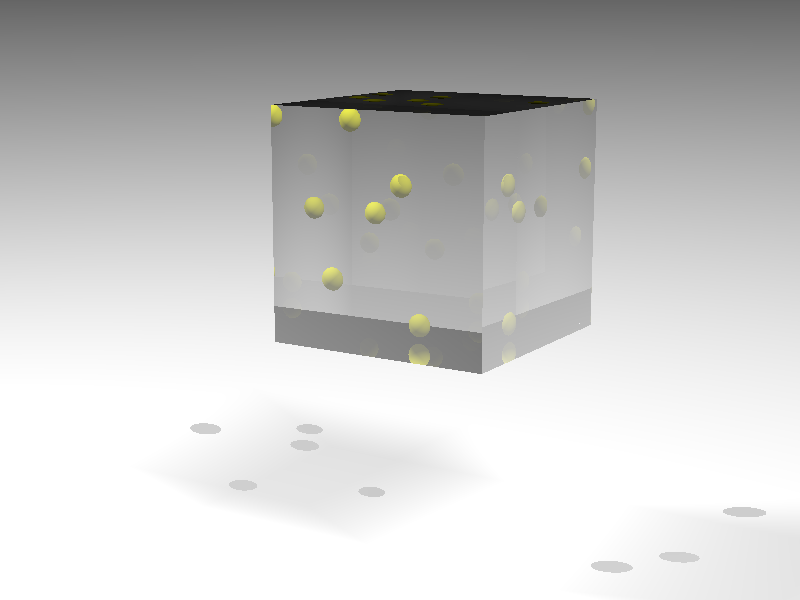

In [142]:
for t in range(32, 33):    
    flnm = 'out/sphere_{:03}.png'.format(t)
    scene = create_scene(t)
    scene.render(flnm, width=800, height=600, remove_temp=False)    
    clear_output()
    display(Image.open(flnm))